# Predictions after removing n channels

Edit the constants.py file, and correct the paths for `model` and `data` to `../model` and `../data`

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import root_mean_squared_error, r2_score

import sys
sys.path.append("../")

from evaluate_script import read_data, predict

Keys in the HDF5 file: ['exam_id', 'tracings']
len(preds): 100


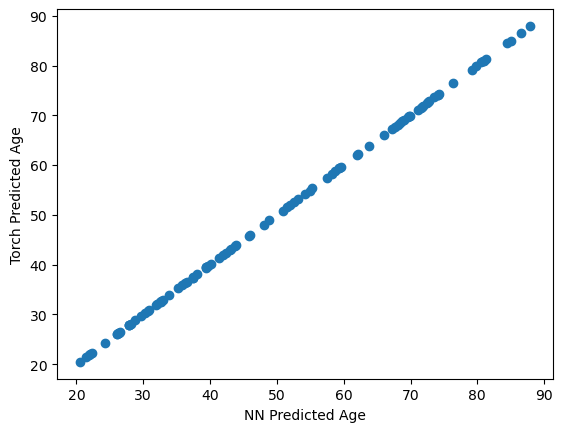

In [2]:
# to predict for the first 100 patients from the file 16
n_total = 100  # to use filters; use a positive number to use first n
batch_size = 20
data_array, df, exam_ids = read_data(n_total=100, data_file='../trace_file.npy')
predict(data_array, df, exam_ids, reconstruct=False, batch_size=batch_size)

In [3]:
df = pd.read_csv("../data/prediction.csv")
df.head()

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file,torch_pred
0,1750214,82,False,67.269160,False,False,False,False,False,False,620960,NaN,NaN,False,exams_part16.hdf5,67.269196
1,1688724,44,False,40.132603,False,False,False,False,False,False,656803,NaN,NaN,True,exams_part16.hdf5,40.132620
2,1771393,51,False,55.314810,False,False,False,False,False,False,1096166,NaN,NaN,False,exams_part16.hdf5,55.314830
3,1793030,28,False,43.013763,False,False,False,False,False,False,1653247,NaN,NaN,False,exams_part16.hdf5,43.013676
4,1717689,52,True,80.612400,False,False,False,False,False,False,647834,NaN,NaN,False,exams_part16.hdf5,80.612380


In [4]:
data_array.shape

(100, 4096, 12)

In [5]:
(df['torch_pred'].notna()).sum(), df.shape

(np.int64(100), (100, 16))

# Remove one channel, replace with the average of the rest of the channels

In [6]:
data_array.shape

(100, 4096, 12)

### How to take mean for a channel in between

* Set that channel to nan
* Use np.nanmean

In [7]:
trace = data_array[:1, :, :]
trace.shape

(1, 4096, 12)

In [8]:
trace[:, :, 0] = np.nan
trace0_mean = np.nanmean(trace[:, :, :], axis=2)

In [9]:
subject0_mean = np.mean(data_array[:1, :, 1:], axis=2)
(abs(trace0_mean - subject0_mean)).max()

np.float32(1.1920929e-07)

<Axes: >

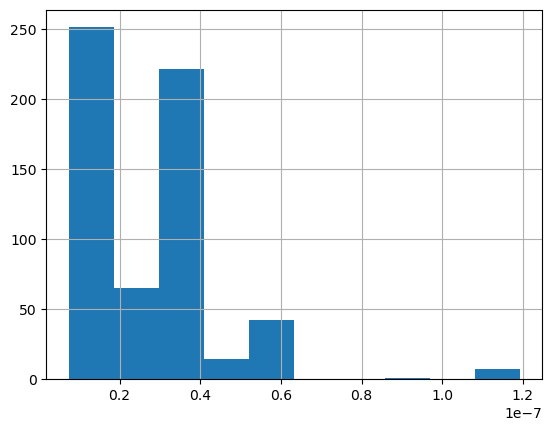

In [10]:
# Mostly the difference is 0. If not, it's ~ 10e-07; much smaller than the recorded voltages
diff = pd.Series(abs(trace0_mean - subject0_mean)[0, :])
diff[diff > 0].hist()

# Run it for all channels, one at a time

In [13]:
n_chan = 1

outdir = "../data/n_chan_removal"
Path(outdir).mkdir(parents=True, exist_ok=True)

for chan in range(12):
    data_array_chan = data_array.copy()
    # replace the channel with nan
    data_array_chan[:, :, chan] = np.nan
    # replace the nans with the nanmean, take mean only for the channel axis
    data_array_chan[:, :, chan] = np.nanmean(data_array_chan, axis=2)
    # predict
    predict(
        data_array_chan,
        df[['exam_id', 'age', 'nn_predicted_age']],
        exam_ids,
        reconstruct=False,
        batch_size=batch_size,
        outfile=f"{outdir}/prediction_chan{chan}.csv",
        keep_orig_cols=False,
    )

In [34]:
df_out = df[['exam_id', 'age', 'nn_predicted_age']].copy()
for chan in range(12):
    df_c = pd.read_csv(f"{outdir}/prediction_chan{chan}.csv")
    df_c.columns = ['exam_id', f'pred_age_wo_chan_{chan}']
    df_out = df_out.merge(
        df_c,
        on='exam_id',
    )
    # rmse = round(root_mean_squared_error(df_c['nn_predicted_age'], df_c['torch_pred']), 2)
    # plt.scatter(df_c['nn_predicted_age'], df_c['torch_pred'], label=f"Channel: {chan}; RMSE: {rmse}")
    # plt.legend()
    # plt.show()

df_out.to_csv("../data/preds_one_chan_removed.csv", index=False)

In [15]:
r2 = []
rmse = []

for chan in range(12):
    r2.append(r2_score(df_out['nn_predicted_age'], df_out[f'pred_age_wo_chan_{chan}']))
    rmse.append(root_mean_squared_error(df_out['nn_predicted_age'], df_out[f'pred_age_wo_chan_{chan}']))


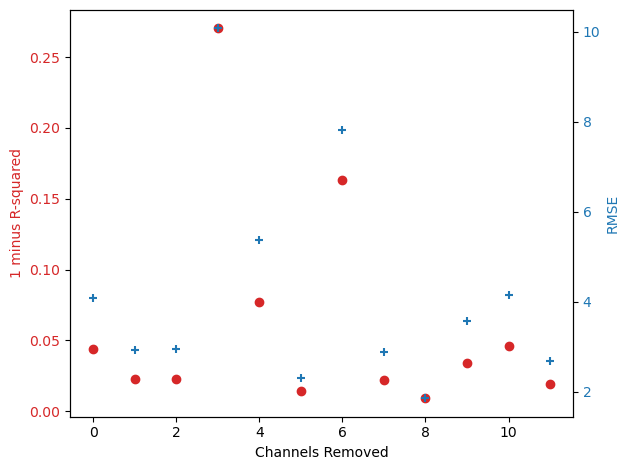

In [33]:
channels = [chan for chan in range(12)]
rmse = np.array(rmse)
r2 = np.array(r2)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Channels Removed')
ax1.set_ylabel('1 minus R-squared', color=color)
ax1.scatter(channels, 1 - r2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.scatter(channels, rmse, color=color, marker='+')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [59]:
df = pd.read_csv("../data/exams.csv")

In [41]:
combs = [comb for comb in combinations([x for x in range(3)], r=2)]
combs

[(0, 1), (0, 2), (1, 2)]

In [43]:
for comb in combs:
    print('_'.join([str(c) for c in comb]))

0_1
0_2
1_2


In [40]:
df_out.to_csv("../data/preds_one_chan_removed.csv", index=False)

In [4]:
df_out = df[['exam_id', 'age', 'nn_predicted_age']].copy()

two_chan_combs = [comb for comb in combinations([x for x in range(12)], r=2)]


In [9]:
(df['exam_id'].isin(exam_ids[:100])).sum()

np.int64(100)

In [10]:
outdir_2 = "data/n_chan_removal/two_chan"
Path(outdir_2).mkdir(parents=True, exist_ok=True)
df = pd.read_csv("../data/prediction.csv")


for chans in two_chan_combs:
    data_array_chan = data_array.copy()
    chan_str = '_'.join([str(chan) for chan in chans])
    for chan in chans:
        # replace the channel with nan
        data_array_chan[:, :, chan] = np.nan
    # replace the nans with the nanmean, take mean only for the channel axis
    data_array_chan[:, :, chan] = np.nanmean(data_array_chan, axis=2)
    # predict
    predict(
        data_array_chan,
        df[['exam_id', 'age', 'nn_predicted_age']],
        exam_ids[:100],
        reconstruct=False,
        batch_size=batch_size,
        outfile=f"{outdir_2}/prediction_chan{chan_str}.csv",
        keep_orig_cols=False,
    )
    break

len(preds): 100
(0, 2)


In [51]:
df_ = pd.read_csv("data/n_chan_removal/two_chan/prediction_chan0_9.csv")
df_.head()

,exam_id,torch_pred


In [55]:
df.shape

(100, 16)

In [ ]:

for chans in two_chan_combs:
    chan_str = '_'.join([str(chan) for chan in chans])
    df_c = pd.read_csv(f"{outdir}/prediction_chan{chan_str}.csv")
    df_c.columns = ['exam_id', f'pred_age_wo_chan_{chan_str}']
    df_out = df_out.merge(
        df_c,
        on='exam_id',
    )